## Section B: Gaussian Process

Gaussian Process is one of the most popular surrogate models for the Bayesian Optimisation workflow. The last question of Section A asked of what the similarities and differences are between the conditioning excersise and GP regression as seen in the figures below. 

Conditioning Excersise:
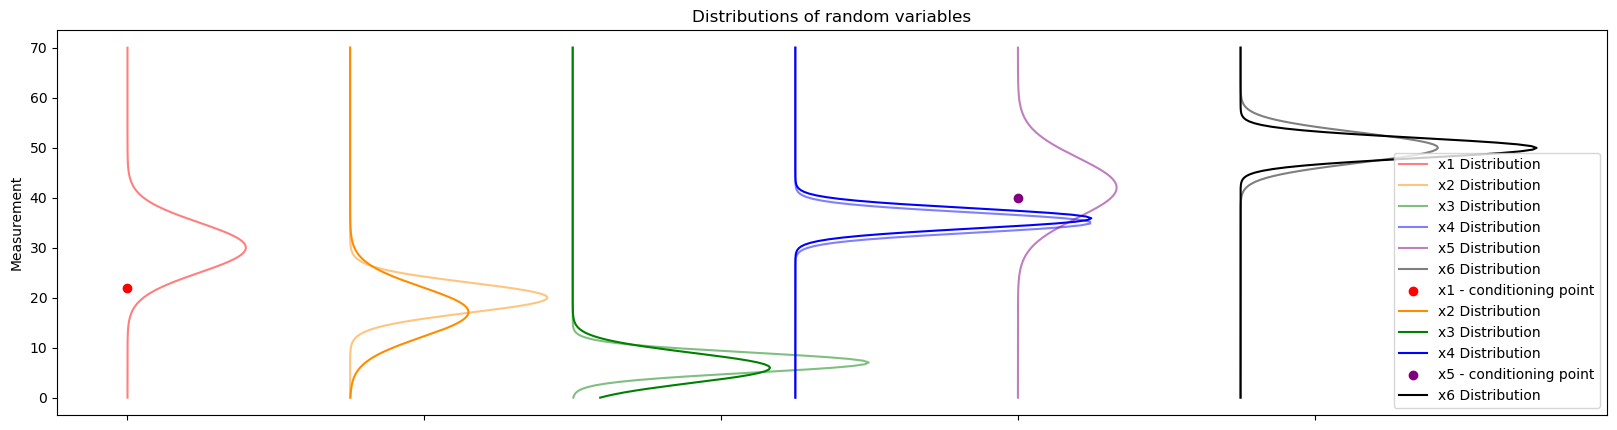

Gaussian Process Regession: 
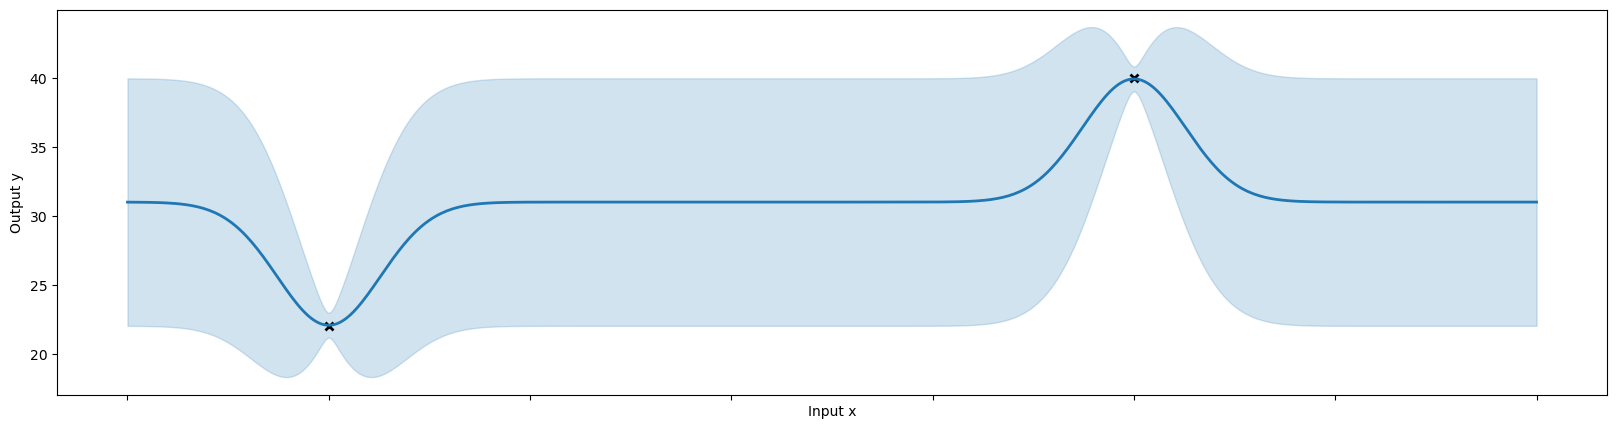

A key similarity is that the conditioning excersise used exact points to condition and to determine the conditioned mean and variance of other variables. This can be seen as data points which we use as training data for the Gaussian Process. 

A key difference is that in the Gaussian Process regression, we (usually) only have some data points and do not have the nessasry information (mean vector and covariance matrix) to relate and predict the conditioned mean and variance of other points. Hence, for a GP regression to work, we have to make some assumptions about the mean vector and covariance matrix to allow for conditioning. 

Also, another (perhaps more obvious) difference is that the conditioning excersise was not an excersise of regression. In this section, we will explore how GPs can be used as models to relate inputs to an output. 

### Importing Relevant Packages
(Feel free to import any packages you feel like needing to fully explore the content!)

In [ ]:
# if using google collab, run the following pip installs!
!pip install sobol_seq
!pip install plotly
!pip install gpytorch
!pip install rdkit

In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.integrate import quad
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
import math
import time
import sobol_seq

### Gaussian Process Regressor

Below is a full Gaussian Processes Regressor coded as a class - it might seem a little complicated, but do not worry! We will break the code down to gather an understanding of how the Gaussian Process is built. Feel free to copy te code and modify it to explore how changes to the code influences the Gaussian Process.

There are many implimentations of a Gaussian Process Regressor. The following is one of many different implimentations.

``` python
class GP_model_meanzero:

    def __init__(self, X, Y, kernel, hyperparams_multistart_loops):
        self.X, self.Y, self.kernel = X, Y, kernel
        self.number_of_point, self.nx_dimensions, self.ny_dimensions = X.shape[0], X.shape[1], Y.shape[1]
        self.multistart_loops            = hyperparams_multistart_loops

        #Normalisation
        self.X_mean, self.X_std     = np.mean(X, axis=0), np.std(X, axis=0)
        self.Y_mean, self.Y_std     = np.mean(Y, axis=0), np.std(Y, axis=0)
        self.X_norm, self.Y_norm    = (X-self.X_mean)/self.X_std, (Y-self.Y_mean)/self.Y_std

        #Determine Kernel Hyperparameters 
        self.hyperparam_optimized , self.inverse_covariance_matrix_opt   = self.determine_hyperparameters()     
        
    def Cov_mat(self, kernel, X_norm, W, sf2):
        if kernel == 'SquaredExponential':
            xixj_euclidean_distance = cdist(X_norm, X_norm, 'seuclidean', V=W)**2 
            cov_matrix = sf2*np.exp(-0.5*xixj_euclidean_distance)
            return (cov_matrix)
        else:
            print('ERROR no kernel with name ', kernel)


    def negative_loglikelihood(self, hyper, X, Y):
        # internal parameters
        n_point, nx_dim = self.number_of_point, self.nx_dimensions
        kernel          = self.kernel
         
        W               = np.exp(2*hyper[:nx_dim])   # W <=> 1/lambda
        sf2             = np.exp(2*hyper[nx_dim])    # variance of the signal 
        sn2             = np.exp(2*hyper[nx_dim+1])  # variance of noise

        # obtaining negative logliklihood via Cholesky decomposition 
        K       = self.Cov_mat(kernel, X, W, sf2)  
        K       = K + (sn2 + 1e-8)*np.eye(n_point) 
        K       = (K + K.T)*0.5                   
        L       = np.linalg.cholesky(K)            
        logdetK = 2 * np.sum(np.log(np.diag(L)))   
        invLY   = np.linalg.solve(L,Y)             
        alpha   = np.linalg.solve(L.T,invLY)       
        NLL     = np.dot(Y.T,alpha) + logdetK     
        return (NLL)

    
    def determine_hyperparameters(self): 
        # setting up bounds for the log likelyhood minimsation
        lower_bound = np.array([-4.]*(self.nx_dimensions+1) + [-8.])  # lengthscales + signal variance, noise variance
        upper_bound = np.array([4.]*(self.nx_dimensions+1) + [ -2.]) 
        bounds      = np.hstack((lower_bound.reshape(self.nx_dimensions+2,1), upper_bound.reshape(self.nx_dimensions+2,1)))

        #gives number of input set of random starting guesses for each hyperparameter
        multi_startvec         = sobol_seq.i4_sobol_generate(self.nx_dimensions + 2, self.multistart_loops)
        
        #variables for storing information during loop
        temp_min_hyperparams   = [0.]*self.multistart_loops
        temp_loglikelihood     = np.zeros((self.multistart_loops))
        hyperparam_optimized   = np.zeros((self.nx_dimensions+2, self.ny_dimensions)) #for best solutions
        inverse_covariance_matrix_opt = []
        
        #minimisation of hyperparameters
        for i in range(self.ny_dimensions):
            for j in range(self.multistart_loops ):
                #initilising hyperparam guess
                hyperparams_initialisation   = lower_bound + (upper_bound-lower_bound)*multi_startvec[j,:] # mapping sobol unit cube to boudns
               
                result = minimize(self.negative_loglikelihood,
                               hyperparams_initialisation,
                               args=(self.X_norm, self.Y_norm[:,i]),
                               method='SLSQP',
                               options={'disp':False,'maxiter':10000},
                               bounds=bounds,
                               tol=1e-12)
                
                temp_min_hyperparams[j] = result.x
                temp_loglikelihood[j]   = result.fun  

            # choosing best solution from temporary lists
            minimumloglikelihood_index    = np.argmin(temp_loglikelihood)
            hyperparam_optimized[:,i]     = temp_min_hyperparams[minimumloglikelihood_index  ]
    
            # exponential to recover value from log space
            lengthscale_opt         = np.exp(2.*hyperparam_optimized[:self.nx_dimensions,i])
            signalvarience_opt      = np.exp(2.*hyperparam_optimized[self.nx_dimensions,i])
            noise_opt               = np.exp(2.*hyperparam_optimized[self.nx_dimensions+1,i]) + 1e-8
    
            #obtain convarience matrix from optimised kernel hyper parameters
            covarience_matrix_opt              = self.Cov_mat(self.kernel, self.X_norm, lengthscale_opt,signalvarience_opt) + noise_opt*np.eye(self.number_of_point)
            self.covarience_matrix_opt         = covarience_matrix_opt
            inverse_covariance_matrix_opt     += [np.linalg.solve(covarience_matrix_opt, np.eye(self.number_of_point))]
            
        return (hyperparam_optimized , inverse_covariance_matrix_opt)

    def calc_cov_sample(self,xnorm,Xnorm,ell,sf2):
        # internal parameters
        nx_dim = self.nx_dimensions

        #covariance of sample
        dist = cdist(Xnorm, xnorm.reshape(1,nx_dim), 'seuclidean', V=ell)**2
        cov_matrix = sf2 * np.exp(-.5*dist)
        return (cov_matrix )         


    def GP_inference_np(self, x):
        nx_dim                   = self.nx_dimensions
        kernel, ny_dim           = self.kernel, self.ny_dimensions
        hypopt, Cov_mat          = self.hyperparam_optimized, self.Cov_mat
        stdX, stdY, meanX, meanY = self.X_std, self.Y_std, self.X_mean, self.Y_mean
        calc_cov_sample          = self.calc_cov_sample
        invKsample               = self.inverse_covariance_matrix_opt
        Xsample, Ysample         = self.X_norm, self.Y_norm

        xnorm = (x - meanX)/stdX
        mean  = np.zeros(ny_dim)
        var   = np.zeros(ny_dim)
        
        # ny_dim -> number of outputs
        for i in range(ny_dim):
            invK           = invKsample[i]
            hyper          = hypopt[:,i]
            ellopt, sf2opt = np.exp(2*hyper[:nx_dim]), np.exp(2*hyper[nx_dim])

            # calculation of covaraince for each output
            # although noise hyperparameter determiend, it is ignored here for better visualisation
            k       = calc_cov_sample(xnorm,Xsample,ellopt,sf2opt)
            mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
            var[i]  = max(0, sf2opt - np.matmul(np.matmul(k.T,invK),k)) 

        # un-normalisation (obtianing actual mean and variance) 
        mean_sample = mean*stdY + meanY
        var_sample  = var*stdY**2
        
        return (mean_sample, var_sample)




```

### B1: Covariance Matrix and Kernel Functions 

We are first exploring the covariance matrix. We have observed previously that the covariance matrix has diagonal elements which describes the variance of each input point and off diagonal points which describes the co-variance. In defining a covariance matrix that can describe generally the relationship between points, a suitable assumption is such that points in which are closer in the input space wil have a closer output. This means that points which are close are more correlated than points that are further away. 

Mathematically, we can describe a function $k({x^i}, {x^j})$ which takes in two points ${x^i}$ and ${x^j}$ in the input space and outputs the correlation. These functions are called kernel functions.  

The covarience matrix can be then constructed as a N x N matrix of these kernel functions where N is the number of points in the input space.
$$
K(X, X) \;=\;
\begin{bmatrix}
k\bigl(x^{(1)},x^{(1)}\bigr) & \cdots & k\bigl(x^{(1)},x^{(n_d)}\bigr) \\[6pt]
\vdots                       & \ddots & \vdots                       \\[6pt]
k\bigl(x^{(n_d)},x^{(1)}\bigr) & \cdots & k\bigl(x^{(n_d)},x^{(n_d)}\bigr)
\end{bmatrix}
$$




#### Excersise B1_1: 
##### Concepts: Kernel Functions

An example of a kernel function is the squared exponential function. 

For one dimension, the squared exponential has the function. 

$$
k\bigl(x^{(i)}, x^{(j)}\bigr)
\;=\;
\sigma_f^2
\exp\!\Bigl[-\,w\,\bigl(x^{(i)} - x^{(j)}\bigr)^2\Bigr]
$$

There are two hyper parameters associated with the function. 
$\sigma_f^2$ is the signal varience. $w$ is associated to the length scale $l$ by the relationship $l = 1/w$ . These parameters will be 'fitted' to the training data during a regular GP regressor routine. We will explore how the hyperparameters influence the kernel function outputs.

For now, write a function for the 1 dimensional kernel function which takes in xi, xj, w and sv2 as the inputs and return the correlation

```python
def squared_exponential_1D(xi, xj, w, sv2):
    return(...)
```

Using the function, plot a 3d plot of the correlation with xi and xj be derived from x_array where:
``` python
x_array = np.linspace (-10, 10, 500) 

#one can use a nested loop to differentiate i and j values. Example: 
for i in x_array:
    for j in x_array: 
        ...
```
Let the $\sigma_f^2 = 0.04$ and $w = 1$. It will be useful to visualize the relationship as a contour plot.

What do you notice about the relationship between the distance of two input points and the correlation. Does it follow that the greater the difference, the lower the correlation? 

How does the rate of change of the correlation when going from points of low distance to points of high distannce? is it linear? quadratic? logarithmic? Hint: observe the equation!


#### Excersise B1_2: 
##### Concepts: Kernel Hyperparameters
We are now going to observe how the hyperperameters modify the output of the kernel function. Using the function you previously defined, plot the kernel function as a input of xi and xj with varying w and sf2. 

When varying w, what do you notice about the correlation between two input points? Does the correlation at 2 points which are far away increase or decrease with increasing w? 

When varying sf2, observe the correlation on the z axis. What is the maximum value of the correlation? How does it change when changing sf2?

#### Excersise B1_3:
##### Concepts: Multidimensional Kernel Function

We now look the multidimensional form of the kernel function. 

$$
k\bigl(x^{(i)}, x^{(j)}\bigr)
\;=\;
\sigma_f^2
\exp\!\Bigl(-\tfrac{1}{2}\,(x^{(i)} - x^{(j)})^T \,W\, (x^{(i)} - x^{(j)})\Bigr)
$$

We do not need to code a function for this as it is already written! Please observe the GP_model_meanzero class above to see where the multidimentsional kernel is implimented and how it is used to form the covariance matrix. Notice also how the training data is prepared via normalisation prior to the construction of the kernel. 

We can now use the class to obtain the covariance matrix of a training data set! We will use a 1D example with input $x$ and the objective function as $sin(x)$. We first have to prepare the training data. (the code in implimented in a way that takes inputs with shape of N x M where N is the number of data points and M is the number of dimensions. Then, we can build the GP_model_object and access attributes 

Please run: (please also execute the cell containing GP_model_meanzero class)
``` python
# define and reshape training data
Xtrain = np.array([-4,-1.5,-1,0])
ndata  = Xtrain.shape[0]
Xtrain = Xtrain.reshape(ndata,1)

Ytrain = np.sin(Xtrain)

# build the GP object (instance of the DP_model_meanzero class)
GP_m = GP_model_meanzero(Xtrain, Ytrain, 'SquaredExponential',  hyperparams_multistart_loops=3)
```

We will come to see how the full GP regressor is implimented. But use this oppertunity to be familar with how the input is formatted and the various attributes that one can call upon from the class. 

To access all the possible instance attributes of an object, please use the `vars()` fucntion on the object. To access an individual instance attribute, use the object method. For example, to observe the covariance matrix of the training data, we would execute: 

```python
GP_m.covarience_matrix_opt
```

#### Excersise B1_4:
##### Concepts: Conditioning on Training Data

Recall in Section A where it was shown how the mean and variance of other points can be obtained through conditioning.

$$
\begin{aligned}
p(\mathbf{x}_1\mid\mathbf{x}_2) &= \mathcal{N}\bigl(\mathbf{x}_1;\,\boldsymbol{\mu}_{x_1\mid x_2},\,\Sigma_{x_1\mid x_2}\bigr)\\[6pt]
\boldsymbol{\mu}_{x_1\mid x_2} &= \boldsymbol{\mu}_{x_1} \;+\;\Sigma_{x_1 x_2}\,\Sigma_{x_2}^{-1}\,(\mathbf{x}_2-\boldsymbol{\mu}_{x_2})\\[6pt]
\Sigma_{x_1\mid x_2} &= \Sigma_{x_1} \;-\;\Sigma_{x_1 x_2}\,\Sigma_{x_2}^{-1}\,\Sigma_{x_2 x_1}
\end{aligned}
$$

With the covariance matrix obtained from the evaluation of the kernel function (we will see how the hyper parameters are learnt in the next section), we can now obtain the mean and variance of every input data points through a similar way - through conditioning! 

Mathematically, the mean and variance for point (${x_n}$) is obtained through a similar form by conditioning on input points $X$, output $Y$ and the covariance matrix $K(X,X)$. 

$$
\begin{aligned}
p\bigl(f \mid X, Y\bigr)
&= \mathcal{GP}\bigl(f;\,\mu_{XY}(\cdot),\,\sigma^2_{XY}(\cdot,\cdot)\bigr) \\[8pt]
\mu_{XY}(x_n)
&= m(x_n)+K(x_n, X)\,K(X,X)^{-1}\,\bigl(Y - m(X)\bigr)\\[6pt]
\sigma^2_{XY}(x_n, X)
&= K(x_n, x_n)\;-\;K(x_n, X)\,K(X,X)^{-1}\,K(X, x_n) \\[8pt]
K(x_n, X)
&= 
\begin{bmatrix}
k\bigl(x_n, x^{(1)}\bigr) & \cdots & k\bigl(x_n, x^{(n_d)}\bigr)
\end{bmatrix}
\end{aligned}
$$

Here, the conditioned mean is dependant on a mean function. We will explore how the mean function influences the GP regressor later. For now, this is set to a zero matrix. With this, the mean vector simplifies to the following.

$$
\begin{aligned}
\mu_{XY}(x_n)
&= K(x_n, X)\,K(X,X)^{-1}\,Y\\
\end{aligned}
$$

We can also include a noise term. This is useful when there is noise during sampling. The nosie term is a hyperparameter that is learnt. (Although the implimentation of GP here accoutns for the noise, the inference does not take it into account such that visualisation of the GP output is easier.)

$$
\begin{aligned}
\mu_{XY}(x_n)
&= K(x_n, X)\,[K(X,X)+{\sigma_n^2}I]^{-1}\,Y\\\\[6pt]
\sigma^2_{XY}(x_n, X)
&= K(x_n, x_n)\;-\;K(x_n, X)\,[K(X,X)+{\sigma_n^2}I]^{-1}\,K(X, x_n) \\[8pt]
\end{aligned}
$$



For this excersise, observe the function GP_inference_np within the GP_model_zeromean class and see how the equations are implimented to obtain the mean and variance of every point in the interested region of the x input space.

We will now obtain the GP model of the input space with $x$ between -5 to 5 conditioned on the training points listed earlier. Observe how the input space (test data) is prepared and used to obtain the mean and variance via the GP_inference_np attribute. 

``` python
# define the interested input space (test data) 
n_test      = 500
Xtest       = np.linspace(-5, 5, num=n_test)

# create the correct sized zero matrices to store the mean and standard deviation
Ytest_mean  = np.zeros(n_test)
Ytest_std   = np.zeros(n_test)

# use GP to predict test data by calling on the GP_inference_np attribute
for ii in range(n_test):
    m_ii, std_ii   = GP_m.GP_inference_np(Xtest[ii])
    Ytest_mean[ii] = m_ii 
    Ytest_std[ii]  = std_ii
```

We can then plot the mean and standard deviation to show the outcome of the GP model! After plotting, observe how the confidence interval (here, is set to +- 3 standard deviations) changes as we move further away from the training data points? What do we observe this behavior? Link this back to the kernel function and the covariance matrix!

``` python
ax = plt.figure(figsize = (8,4), dpi = 100)

# plot observed points
plt.plot(Xtrain, Ytrain, 'kx', mew=2)

# plot the objective function to see compare the GP model to
fx_test     = np.sin(Xtest)
plt.plot(Xtest, fx_test, 'black', linewidth=1)

# plot GP mean
plt.plot(Xtest, Ytest_mean, 'C0', lw=2)

# plot GP confidence intervals - here it is set to 3 standard deviations
plt.gca().fill_between(Xtest.flat, 
                       Ytest_mean - 3*np.sqrt(Ytest_std), 
                       Ytest_mean + 3*np.sqrt(Ytest_std), 
                       color='C0', alpha=0.2)

plt.title('Gaussian Process Regression')
plt.legend(('Training Data', 'Objective Function', 'GP mean', 'GP Confidence Interval'),
           loc='lower right')
plt.show()

```

#### Excersise B1_5:
##### Concepts: GP regession

It is your turn to perform GP regression! Show a plot similar to that generated in the previous excersise of a GP regression conditioned on the training data and objective function specified. 

``` python
# x training data set based on [0.1,0.3,0.4,0.8,2,2.1]
# y training data set based objective function sin(x^x)
# interested x input space from 0 to 3
```

Is the GP regressor better for extrapolation beyond the training data set? What values obtained from the regressor can allow us to make a judgement on the confidence of the predicted mean. 

#### Excersise B1_6:
##### Concepts: Kernel function Hyperparameters

Well done! You have now sucessfully performed a GP regression! 

In this section, we will see how the hyperparameters influence the kernel functions similar to how we have shown it in excersise B1_1.

The hyperparameters are 'learnt' by minimizing the negative log likelihood. 

$$
\mathcal{L}(\Theta)
\;=\;
-\log p(Y\mid X)
\;=\;
\frac{1}{2}\,Y^T\,K(\Theta)^{-1}\,Y
\;+\;
\frac{1}{2}\,\log\!\bigl(\det K(\Theta)\bigr)
$$

This equation is derived from the probability of the model to reproduce the training data. Observe how in the GP_model_meanzero class the negative loglikelihood is optimised via scipy.optimize.minimize() function. The optimise hyperparameters is what enables the kernel functions and therefore the covariance matrix to be built. 

In this implimentation of GP, there are N + 2 number of hyperparameters where N is the total number of dimensions. This involve the signal variance, noise variance and the individual lengthscales for each dimension. From the GP regression you performed, obtain the values of the optimised hyperparameters. These hyperparameters are instance attributes of the object. See excersise B1_3 for hints for obtaining the values.

How would these values change for different objective functions? How can we show this with the code already provided?

#### Excersise B1_6:
##### Concepts: The mean function 

In this final section, we will observe how the mean function alters the GP regressor. So far, we have set the GP mean function to 0. What would change if the mean function was altered? 

Here, the GP_model_meanzero class has been moidified to allow for the mean function to be specified. What are the changes? 

```python
class GP_model_variablemean:

    def __init__(self, X, Y, kernel, hyperparams_multistart_loops):
        self.X, self.Y, self.kernel = X, Y, kernel
        self.number_of_point, self.nx_dimensions, self.ny_dimensions = X.shape[0], X.shape[1], Y.shape[1]
        self.multistart_loops            = hyperparams_multistart_loops
        self.X_mean, self.X_std     = np.mean(X, axis=0), np.std(X, axis=0)
        self.Y_mean, self.Y_std     = np.mean(Y, axis=0), np.std(Y, axis=0)
        self.X_norm, self.Y_norm    = (X-self.X_mean)/self.X_std, (Y-self.Y_mean)/self.Y_std
        self.hyperparam_optimized , self.inverse_covariance_matrix_opt   = self.determine_hyperparameters()     
        
    def Cov_mat(self, kernel, X_norm, W, sf2):
        if kernel == 'SquaredExponential':
            xixj_euclidean_distance = cdist(X_norm, X_norm, 'seuclidean', V=W)**2 
            cov_matrix = sf2*np.exp(-0.5*xixj_euclidean_distance)
            return (cov_matrix)
        else:
            print('ERROR no kernel with name ', kernel)
            
    def negative_loglikelihood(self, hyper, X, Y):
        n_point, nx_dim = self.number_of_point, self.nx_dimensions
        kernel          = self.kernel
        W               = np.exp(2*hyper[:nx_dim])   
        sf2             = np.exp(2*hyper[nx_dim])   
        sn2             = np.exp(2*hyper[nx_dim+1])  
        K       = self.Cov_mat(kernel, X, W, sf2) 
        K       = K + (sn2 + 1e-8)*np.eye(n_point) 
        K       = (K + K.T)*0.5                    
        L       = np.linalg.cholesky(K)           
        logdetK = 2 * np.sum(np.log(np.diag(L)))   
        invLY   = np.linalg.solve(L,Y)             
        alpha   = np.linalg.solve(L.T,invLY)      
        NLL     = np.dot(Y.T,alpha) + logdetK      
        return (NLL)
        
    def determine_hyperparameters(self): 
        lower_bound = np.array([-4.]*(self.nx_dimensions+1) + [-8.]) 
        upper_bound = np.array([4.]*(self.nx_dimensions+1) + [ -2.]) 
        bounds = np.hstack((lower_bound.reshape(self.nx_dimensions+2,1), upper_bound.reshape(self.nx_dimensions+2,1)))
        multi_startvec   = sobol_seq.i4_sobol_generate(self.nx_dimensions + 2, self.multistart_loops)
        temp_min_hyperparams = [0.]*self.multistart_loops
        temp_loglikelihood = np.zeros((self.multistart_loops))
        hyperparam_optimized = np.zeros((self.nx_dimensions+2, self.ny_dimensions)) #for best solutions
        inverse_covariance_matrix_opt = []
        for i in range(self.ny_dimensions):
            for j in range(self.multistart_loops ):
                hyperparams_initialisation   = lower_bound + (upper_bound-lower_bound)*multi_startvec[j,:]
                result = minimize(self.negative_loglikelihood,
                               hyperparams_initialisation,
                               args=(self.X_norm, self.Y_norm[:,i]),
                               method='SLSQP',
                               options={'disp':False,'maxiter':10000},
                               bounds=bounds,
                               tol=1e-12)
                temp_min_hyperparams[j] = result.x
                temp_loglikelihood[j] = result.fun  
            minimumloglikelihood_index    = np.argmin(temp_loglikelihood)
            hyperparam_optimized[:,i] = temp_min_hyperparams[minimumloglikelihood_index  ]
            lengthscale_opt      = np.exp(2.*hyperparam_optimized[:self.nx_dimensions,i])
            signalvarience_opt      = np.exp(2.*hyperparam_optimized[self.nx_dimensions,i])
            noise_opt      = np.exp(2.*hyperparam_optimized[self.nx_dimensions+1,i]) + 1e-8
            covarience_matrix_opt = self.Cov_mat(self.kernel, self.X_norm, lengthscale_opt,signalvarience_opt) + noise_opt*np.eye(self.number_of_point)
            inverse_covariance_matrix_opt     += [np.linalg.solve(covarience_matrix_opt, np.eye(self.number_of_point))]
        return (hyperparam_optimized , inverse_covariance_matrix_opt)

    def calc_cov_sample(self,xnorm,Xnorm,ell,sf2):
        nx_dim = self.nx_dimensions
        dist = cdist(Xnorm, xnorm.reshape(1,nx_dim), 'seuclidean', V=ell)**2
        cov_matrix = sf2 * np.exp(-.5*dist)
        return (cov_matrix )         

    def GP_inference_np(self, x, mean_function):
        nx_dim                   = self.nx_dimensions
        kernel, ny_dim           = self.kernel, self.ny_dimensions
        hypopt, Cov_mat          = self.hyperparam_optimized, self.Cov_mat
        stdX, stdY, meanX, meanY = self.X_std, self.Y_std, self.X_mean, self.Y_mean
        calc_cov_sample          = self.calc_cov_sample
        invKsample               = self.inverse_covariance_matrix_opt
        Xsample, Ysample         = self.X_norm, self.Y_norm
        xnorm = (x - meanX)/stdX
        mean  = np.zeros(ny_dim)
        var   = np.zeros(ny_dim)
        
        for i in range(ny_dim):
            invK           = invKsample[i]
            hyper          = hypopt[:,i]
            ellopt, sf2opt = np.exp(2*hyper[:nx_dim]), np.exp(2*hyper[nx_dim])
            k       = calc_cov_sample(xnorm,Xsample,ellopt,sf2opt)
            mean[i] = mean_function + np.matmul(np.matmul(k.T,invK),(Ysample[:,i]-mean_function))
            var[i]  = max(0, sf2opt - np.matmul(np.matmul(k.T,invK),k)) 

        mean_sample = mean*stdY + meanY
        var_sample  = var*stdY**2
        return (mean_sample, var_sample)
```

#### Excersise B1_7:
##### Concepts: The mean function 

Notice that the mean function that is implimented here is a N by M matrix where N is the number of points and M is the dimension of the inputs. We can now run a modified version of excersise B1_4 with a non-zero mean function. Please execute the code for GP_model_variablemean class. 

We will plot the GP outputs with different mean functions. These are set to a constant value f(x) = C. (One can also modify the mean function to be any function such as a polynomial). What is the effect of modifying the mean function? Hint: observe areas where it is further away from the training points. What do you notice? 

Given in usual senarios that we do not understand the relationship between input and outputs, what is a suitable mean function to use?

``` python
mean_func_list = [1,5,10,20]

for constant in mean_func_list:
    # define and reshape training data
    Xtrain = np.array([-4,-1.5,-1,0])
    ndata  = Xtrain.shape[0]
    Xtrain = Xtrain.reshape(ndata,1)
    Ytrain = np.sin(Xtrain)
    
    # build the GP object (instance of the DP_model_meanzero class)
    GP_m = GP_model_variablemean(Xtrain, Ytrain, 'SquaredExponential',  hyperparams_multistart_loops=3)
    
    # define the interested input space (test data) 
    n_test      = 500
    Xtest       = np.linspace(-5.0, 5.0, num=n_test)
    
    # create the correct sized zero matrices to store the mean and standard deviation
    Ytest_mean  = np.zeros(n_test)
    Ytest_std   = np.zeros(n_test)
    
    # create the mean function
    mean_func = lambda x: constant
    
    # use GP to predict test data by calling on the GP_inference_np attribute
    for ii in range(n_test):
        m_ii, std_ii   = GP_m.GP_inference_np(Xtest[ii], mean_func(Xtest[ii]))
        Ytest_mean[ii] = m_ii 
        Ytest_std[ii]  = std_ii
    
    ax = plt.figure(figsize = (8,4), dpi = 100)
    
    # plot observed points
    plt.plot(Xtrain, Ytrain, 'kx', mew=2)
    
    # plot the objective function to see compare the GP model to
    fx_test     = np.sin(Xtest)
    plt.plot(Xtest, fx_test, 'black', linewidth=1)
    
    # plot GP mean
    plt.plot(Xtest, Ytest_mean, 'C0', lw=2)
    
    # plot GP confidence intervals - here it is set to 3 standard deviations
    plt.gca().fill_between(Xtest.flat, 
                           Ytest_mean - 3*np.sqrt(Ytest_std), 
                           Ytest_mean + 3*np.sqrt(Ytest_std), 
                           color='C0', alpha=0.2)
    
    plt.title(f'Gaussian Process Regression - Mean function f(x) = {constant}')
    plt.legend(('Training Data', 'Objective Function', 'GP mean', 'GP Confidence Interval'),
               loc='lower right')
    plt.show()

```


#### Excersise B1_8:

Final excersise! We will now observe how to perform multidimensional GP regression by observing how to construct the inputs. 

The GP_model_meanzero class is built to recieve multidimensional matrices of shape N x M where N is the number of poinrs and M is the number of dimensions as inputs. One can contruct these multidimensional arrays mannually, or use a recursively. 

```python
Xtrain = array([[-4, -3],
               [-4, -2],
               [-4,  3],
               [-1, -3],
               [-1, -2],
               [-1,  3],
               [ 2, -3],
               [ 2, -2],
               [ 2,  3]])

# the same as

x1loc  = [-4,  -1,  2]; x2loc = [-3, -2, 3]
Xtrain = [[x,y] for x in x1loc for y in x2loc]
X_training = np.array(Xtrain)
```

In this set of excersises, we are only with the optimisation of a one dimensional output. Here is output must be of shape N x M where N is the number of points and M = 1 (for the number of dimension). Example: 

```python
#an objective function defined to take in individual points as a list
def obj_func(X):
	return (np.sin(X[0])+np.sin(X[1]))

#obtaining the function and reshaping to obtain N x 1 matrix
Fx_training     = np.array([obj_func(x) for x in X_training])
Y_training  = Fx_training.reshape(Fx_training.shape[0],1)
```

In the same fashion, we must modify our interested input space and empty matrix to have the correct 2 dimensional shape. 

``` python
number_points_pervariable      = 50
number_points_searchspace   = number_points_pervariable ** (np.shape(X_training)[1])

#Here, the interested search space is symmetrical, if it is non symmetrical, one can define each dimension individually and build the search space recursively
X_searchspace     = np.linspace(-5, 8, num=number_points_pervariable)
X_searchspace     = np.array([[x,y] for x in X_searchspace for y in X_searchspace])

Ysearchspace_mean        = np.zeros(number_points_searchspace)
Ysearchspace_std         = np.zeros(number_points_searchspace)
```

Using the objective function and the training points specified above, can you perform GP regression and obtain the covarience matrix? Can you graph a 3D plot of the predicted average mean with the described search space (compare it with the objective function)? (Standard deviation fill-in regions are difficult to visualise in 3D.) 

What is the predicted output mean and standard deviation of point [1,1]?


### Segue into Bayesian Optimisation!

Well done for getting to this point! You should now be familiar with concepts such as how the covariance is built from kernel functions, how the GP regressor provides predictions on mean with an associated uncertainty and how the mean function affects the predicted mean. 

Bayesian Optimisation is an active learning workflow that utilizes the mean and uncertainty obtained from GP regression to perform optimisation tasks. You should have managed to produce two beautiful graphs from the previous excersise describing the objective function and the predicted mean based on the training points. 

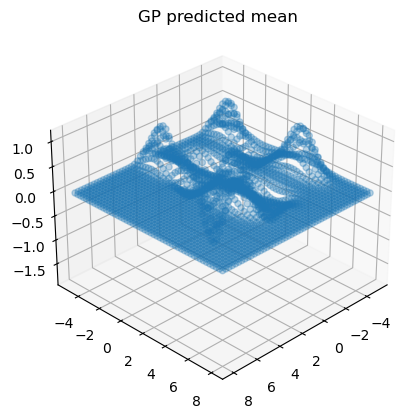
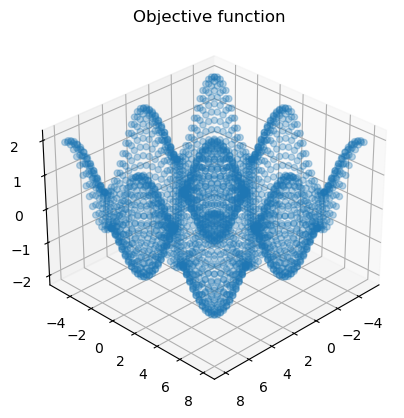

Before heading to section C, have a little think about how the predicted mean and uncertainty can help us find the minima of the objective function if we were able to evaluate additional points beyond that of the initial trianing data.